## Package Import

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

pd.pandas.set_option('display.max_columns', None) 
sns.set_theme(color_codes = True)

import os
import sys
import random
import warnings
warnings.filterwarnings('ignore')

from scipy.stats import f_oneway

# 정답률을 빠르게 구하기 위해 함수 정의
def percentile(s) :
    return np.sum(s) / len(s)

print('='*5 ,'나의 라이브러리 버전 확인', '='*5)
print(f'{"python version":15s} <> {sys.version}')
print(f'{"numpy version":15s} <> {np.__version__}')
print(f'{"pandas version":15s} <> {pd.__version__}')
print(f'{"matplotlib version":15s} <> {matplotlib.__version__}')
print(f'{"seaborn version":15s} <> {sns.__version__}')

===== 나의 라이브러리 버전 확인 =====
python version  <> 3.10.13 (main, Jan  3 2024, 22:18:44) [GCC 7.5.0]
numpy version   <> 1.26.3
pandas version  <> 2.1.4
matplotlib version <> 3.8.2
seaborn version <> 0.13.1


## Data Import

|변수명             |변수 설명|
|------------------|-------------------------------------------------|
|`userID`          |사용자의 고유번호                                 |
|`assessmentItemID`|문항의 고유번호                                   |
|`testId`          |시험지의 고유번호                                 |
|`answerCode`      |사용자가 해당 문항을 맞췄는지 여부에 대한 이진 데이터|
|`Timestamp`       |사용자가 해당 문항을 풀기 시작한 시점의 데이터      |
|`KnowledgeTag`    |문항 당 하나씩 배정되는 태그로, 일종의 중분류 역할  |

In [2]:
%time
dtype = {'userID' : 'int16',
         'answerCode' : 'int8',
         'KnowledgeTag' : 'int16'}   

DATA_PATH = './data/'

train = pd.read_csv(DATA_PATH + 'train_data.csv', dtype = dtype, parse_dates = ['Timestamp'])
train = train.sort_values(by = ['userID', 'Timestamp']).reset_index(drop = True)

test = pd.read_csv(DATA_PATH + 'test_data.csv', dtype = dtype, parse_dates = ['Timestamp'])
test = test.sort_values(by = ['userID', 'Timestamp']).reset_index(drop = True)

print(train.shape, test.shape)

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 7.63 µs
(2266586, 6) (260114, 6)


In [3]:
display(train.head(), train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2266586 entries, 0 to 2266585
Data columns (total 6 columns):
 #   Column            Dtype         
---  ------            -----         
 0   userID            int16         
 1   assessmentItemID  object        
 2   testId            object        
 3   answerCode        int8          
 4   Timestamp         datetime64[ns]
 5   KnowledgeTag      int16         
dtypes: datetime64[ns](1), int16(2), int8(1), object(2)
memory usage: 62.7+ MB


,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225


None

## EDA

### `userID`
- Train Data에는 총 6,698명의 고유한 사용자
- Test Data에는 총 744명의 고유한 사용자
- Train과 Test에 **동일한 사용자는 없음**

In [4]:
print(f"Train Data `userID` Unique Values : {train['userID'].nunique()}")
print(f"Test  Data `userID` Unique Values : {test['userID'].nunique()}")
print(len(set(train['userID']) - set(test['userID'])))

Train Data `userID` Unique Values : 6698
Test  Data `userID` Unique Values : 744
6698


In [5]:
stu_groupby = train.groupby('userID', as_index = False).agg(
    {'assessmentItemID' : 'count', 'answerCode' : percentile})
display(stu_groupby)

,userID,assessmentItemID,answerCode
0,0,745,0.630872
1,1,933,0.853162
2,2,276,0.612319
3,5,833,0.795918
4,6,921,0.442997
...,...,...,...
6693,7436,15,0.466667
6694,7437,16,0.375000
6695,7438,16,0.750000
6696,7440,15,0.400000


In [6]:
user_item_group = train.groupby(['userID', 'assessmentItemID'], as_index = False).size().sort_values(by = 'size', ascending = False)
user_item_group[user_item_group['size'] > 1]

,userID,assessmentItemID,size
367673,517,A080015001,3
367674,517,A080015002,3
367675,517,A080015003,3
367676,517,A080015004,3
367677,517,A080015005,3
...,...,...,...
1575024,2821,A060170004,2
282727,394,A080087005,2
282726,394,A080087004,2
1575035,2821,A060172001,2


#### 사용자 문항 개수 도수분포표

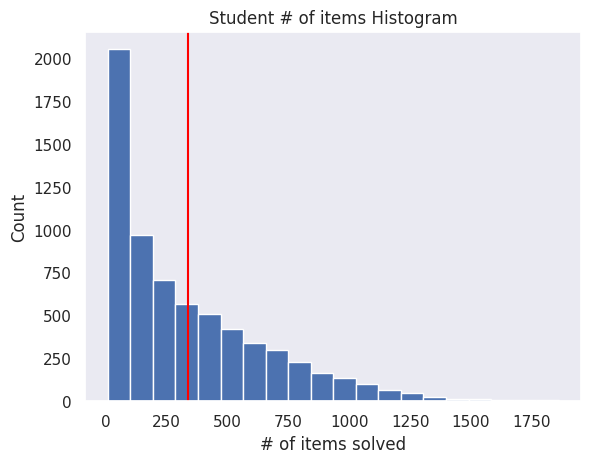

In [7]:
fig, ax = plt.subplots()

stu_groupby['assessmentItemID'].hist(bins = 20, ax = ax)

ax.set_title('Student # of items Histogram')
ax.set_xlabel('# of items solved')
ax.set_ylabel('Count')
ax.axvline(stu_groupby['assessmentItemID'].mean(), color = 'red')
ax.grid(visible = False)
plt.show()

#### 사용자 정답률 도수분포표

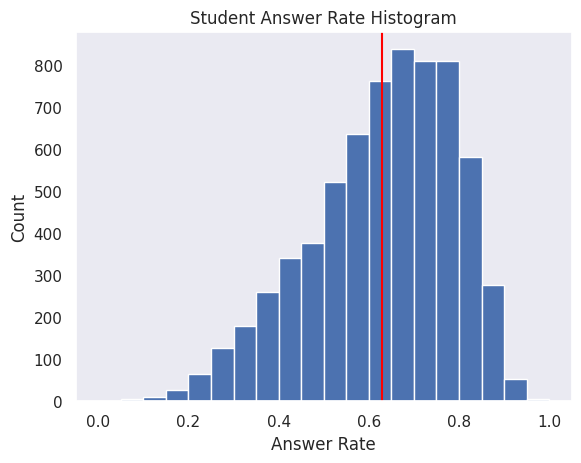

In [8]:
fig, ax = plt.subplots()

stu_groupby['answerCode'].hist(bins = 20)

ax.set_title('Student Answer Rate Histogram')
ax.set_xlabel('Answer Rate')
ax.set_ylabel('Count')
ax.axvline(stu_groupby['answerCode'].mean(), color = 'red')
ax.grid(visible = False)
plt.show()

### `assessmentItemID`
- **총 10자리**로 구성
    - **첫번째 자리**는 항상 **알파벳 A**
    - **2~7번째 자리**는 **시험지 번호**
    - **8~10번째 자리**는 **시험지 내 문항의 번호**

In [9]:
train['assessmentItemID'].apply(lambda x : x[0]).unique()

array(['A'], dtype=object)

#### 문항 별 정답률 분석

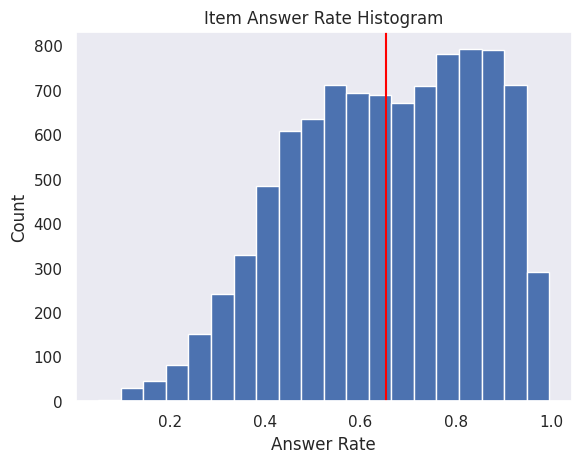

In [10]:
prob_groupby = train.groupby('assessmentItemID', as_index = False).agg(
    {'userID' : 'count', 'answerCode': percentile})

fig, ax = plt.subplots()
prob_groupby['answerCode'].hist(bins = 20)
ax.set_title('Item Answer Rate Histogram')
ax.set_xlabel('Answer Rate')
ax.set_ylabel('Count')
ax.axvline(prob_groupby['answerCode'].mean(), color = 'red')
ax.grid(visible = False)
plt.show()

#### `problemID` 변수 생성 -> 시험지 내 문항의 번호
- `problemID`는 1번 ~ 13번까지 있음
- 문항별 정답률로 `난이도` 변수 생성해도 좋을듯

In [11]:
train['problemID'] = train['assessmentItemID'].apply(lambda x : x[7:])
train['problemID'].value_counts().to_frame()

,count
problemID,
001,371755
003,371640
002,370972
004,369705
005,360607
006,197772
007,127121
008,67150
009,18417


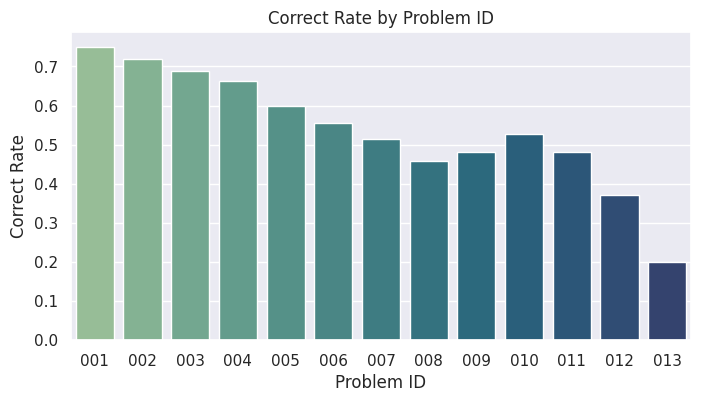

In [12]:
pb_ans_mean = train.groupby('problemID', as_index = False).agg({'answerCode' : percentile})

plt.figure(figsize = (8, 4))

sns.barplot(x = 'problemID', y = 'answerCode', data = pb_ans_mean,
            palette = sns.color_palette(palette = 'crest', n_colors = 13))

plt.title('Correct Rate by Problem ID')
plt.xlabel('Problem ID')
plt.ylabel('Correct Rate')
plt.show()

In [13]:
# ANOVA 수행
result = f_oneway(*[group['answerCode'] for name, group in \
    train[['problemID', 'answerCode']].groupby('problemID')])

# 결과 출력
print('------------------------- ANOVA TEST -------------------------')
print('H0 : 문항 번호 별 정답률은 동일하다.')
print('H1 : 문항 번호 별 정답률은 동일하지 않다.\n')

print(f'F-statistic : {result.statistic:.5f}')
print(f'p-value : {result.pvalue}\n')

# p-value를 기반으로 한 유의성 검정
alpha = 0.05
if result.pvalue < alpha :
    print('p-value < alpha이므로 유의수준 5% 하에서 H0를 기각한다. \n즉, 문항 번호 별 정답률이 적어도 하나는 동일하지 않다.')
else :
    print('p-value > alpha이므로 유의수준 5% 하에서 H0를 기각할 수 없다. \n즉, 문항 번호 별 정답률은 동일하다.')

------------------------- ANOVA TEST -------------------------
H0 : 문항 번호 별 정답률은 동일하다.
H1 : 문항 번호 별 정답률은 동일하지 않다.

F-statistic : 5507.34005
p-value : 0.0

p-value < alpha이므로 유의수준 5% 하에서 H0를 기각한다. 
즉, 문항 번호 별 정답률이 적어도 하나는 동일하지 않다.


### `testID`
- **총 10자리**로 구성
    - **첫번째 자리**는 항상 **알파벳 A**
    - **2~4번째 자리**와 **8~10번째 자리**는 **시험지 번호**
        - 2~4번째 자리 중 **가운데 자리(3번째 자리)만 1~9 값**을 가짐 \
         → 이를 **대분류라는 Feature로 활용**
        - 나머지는 모두 0
    - **5~7번째 자리**는 **모두 000**

**`assessmentItemID`의 1-6번째 자리**와 **`testId`의 1-3번째+마지막3자리** 같은지 확인
-> 모두 동일

In [14]:
sum(train['assessmentItemID'].apply(lambda x : x[1:7]) == train['testId'].apply(lambda x : x[1:4] + x[7:]))

2266586

- 필요한 부분만 추출하여 `testID` 변환
- `testCode`, `testCode2`를 생성하여 정답률 비교

In [15]:
train['testID'] = train['assessmentItemID'].apply(lambda x : x[1:7])
train['testCode'] = train['testID'].apply(lambda x : x[1:2])
train['testCode2'] = train['testID'].apply(lambda x : x[3:])

#### 시험지 별 정답률 분석

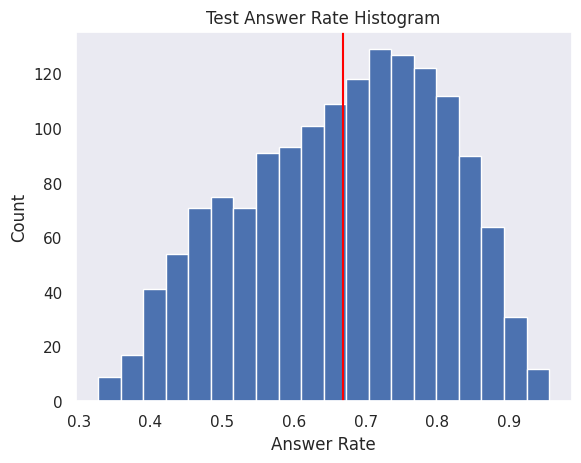

In [15]:
test_groupby = train.groupby('testID', as_index = False).agg(
    {'userID' : 'count', 'answerCode': percentile})

fig, ax = plt.subplots()
test_groupby['answerCode'].hist(bins = 20)
ax.set_title('Test Answer Rate Histogram')
ax.set_xlabel('Answer Rate')
ax.set_ylabel('Count')
ax.axvline(test_groupby['answerCode'].mean(), color = 'red')
ax.grid(visible = False)
plt.show()

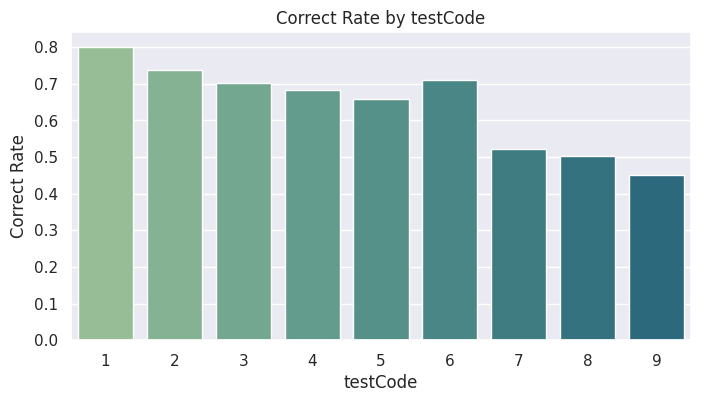

In [16]:
tc_ans_mean = train.groupby('testCode', as_index = False).agg({'answerCode' : percentile})

plt.figure(figsize = (8, 4))

sns.barplot(x = 'testCode', y = 'answerCode', data = tc_ans_mean,
            palette = sns.color_palette(palette = 'crest', n_colors = 13))

plt.title('Correct Rate by testCode')
plt.xlabel('testCode')
plt.ylabel('Correct Rate')
plt.show()

In [17]:
# ANOVA 수행
result = f_oneway(*[group['answerCode'] for name, group in \
    train[['testCode', 'answerCode']].groupby('testCode')])

# 결과 출력
print('------------------------- ANOVA TEST -------------------------')
print('H0 : 시험지 번호(2~4번째) 별 정답률은 동일하다.')
print('H1 : 시험지 번호(2~4번째) 별 정답률은 동일하지 않다.\n')

print(f'F-statistic : {result.statistic:.5f}')
print(f'p-value : {result.pvalue}\n')

# p-value를 기반으로 한 유의성 검정
alpha = 0.05
if result.pvalue < alpha :
    print('p-value < alpha이므로 유의수준 5% 하에서 H0를 기각한다. \n즉, 시험지 번호(2~4번째) 별 정답률이 적어도 하나는 동일하지 않다.')
else :
    print('p-value > alpha이므로 유의수준 5% 하에서 H0를 기각할 수 없다. \n즉, 시험지 번호(2~4번째) 별 정답률은 동일하다.')

------------------------- ANOVA TEST -------------------------
H0 : 시험지 번호(2~4번째) 별 정답률은 동일하다.
H1 : 시험지 번호(2~4번째) 별 정답률은 동일하지 않다.

F-statistic : 14479.77398
p-value : 0.0

p-value < alpha이므로 유의수준 5% 하에서 H0를 기각한다. 
즉, 시험지 번호(2~4번째) 별 정답률이 적어도 하나는 동일하지 않다.


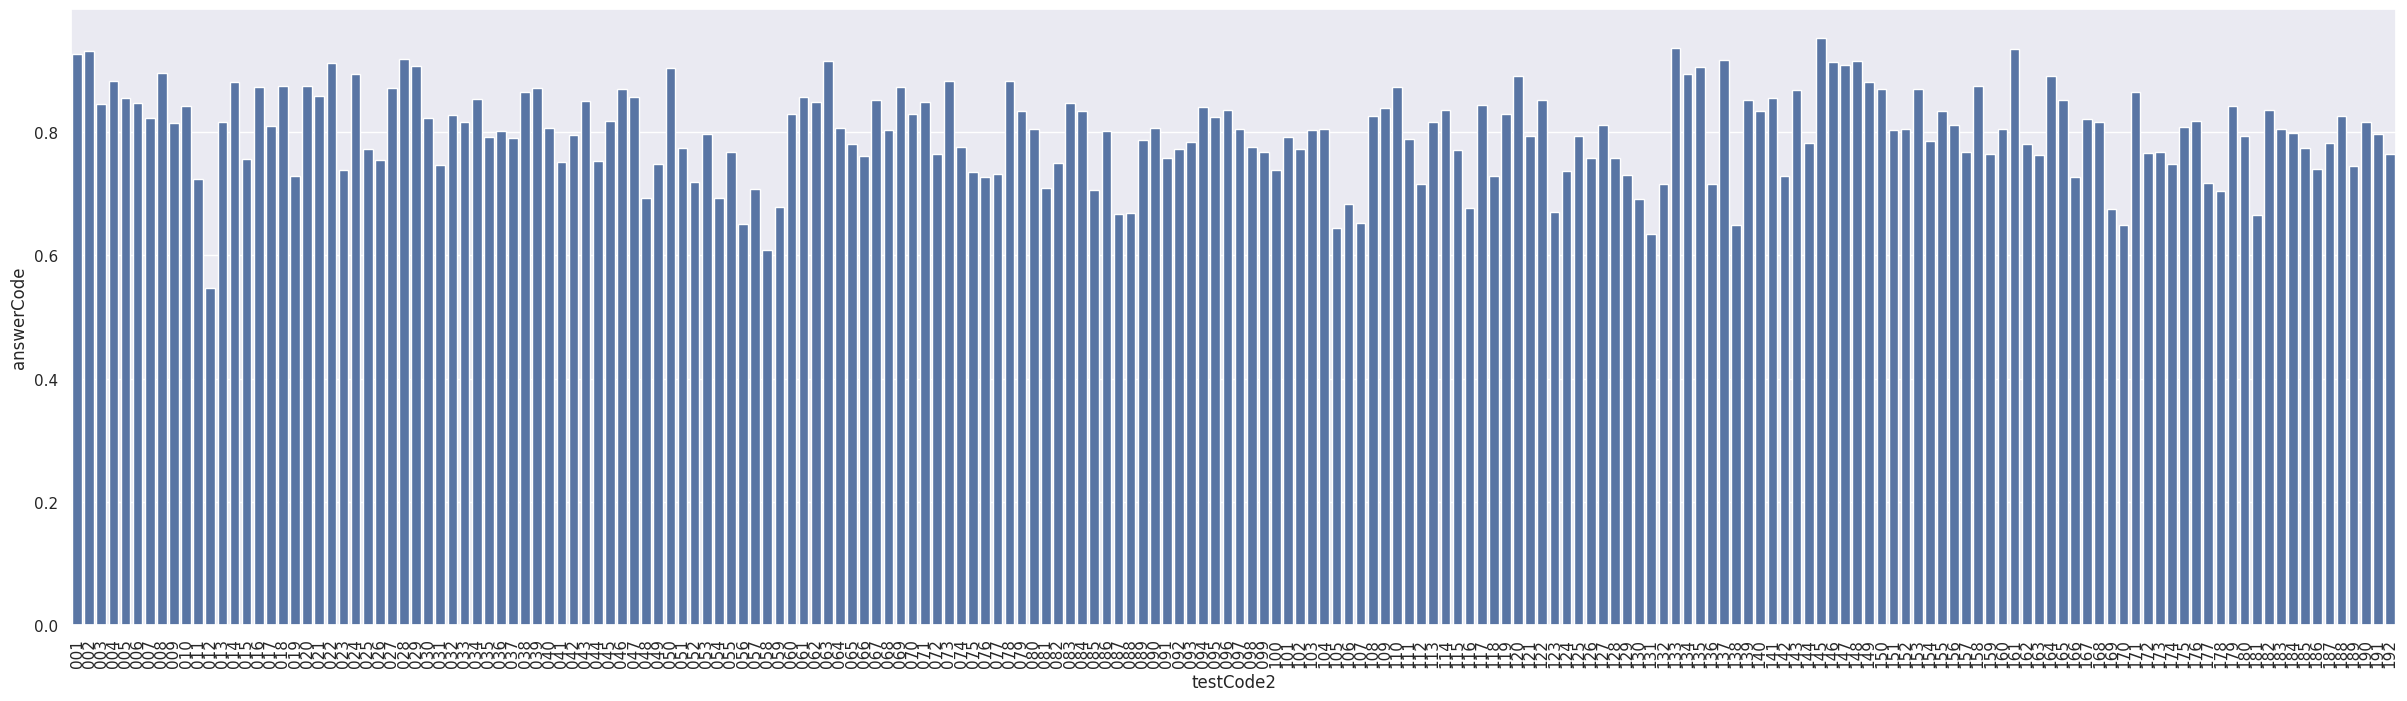

In [18]:
plt.figure(figsize = (30, 8))
test_group = train.groupby(['testCode', 'testCode2'], as_index = False).agg({'answerCode' : percentile})
test010_group = test_group[test_group['testCode'] == '1']
sns.barplot(x = 'testCode2', y = 'answerCode', data = test010_group)
plt.xticks(rotation = 90)
plt.show()

<Figure size 3000x3000 with 0 Axes>

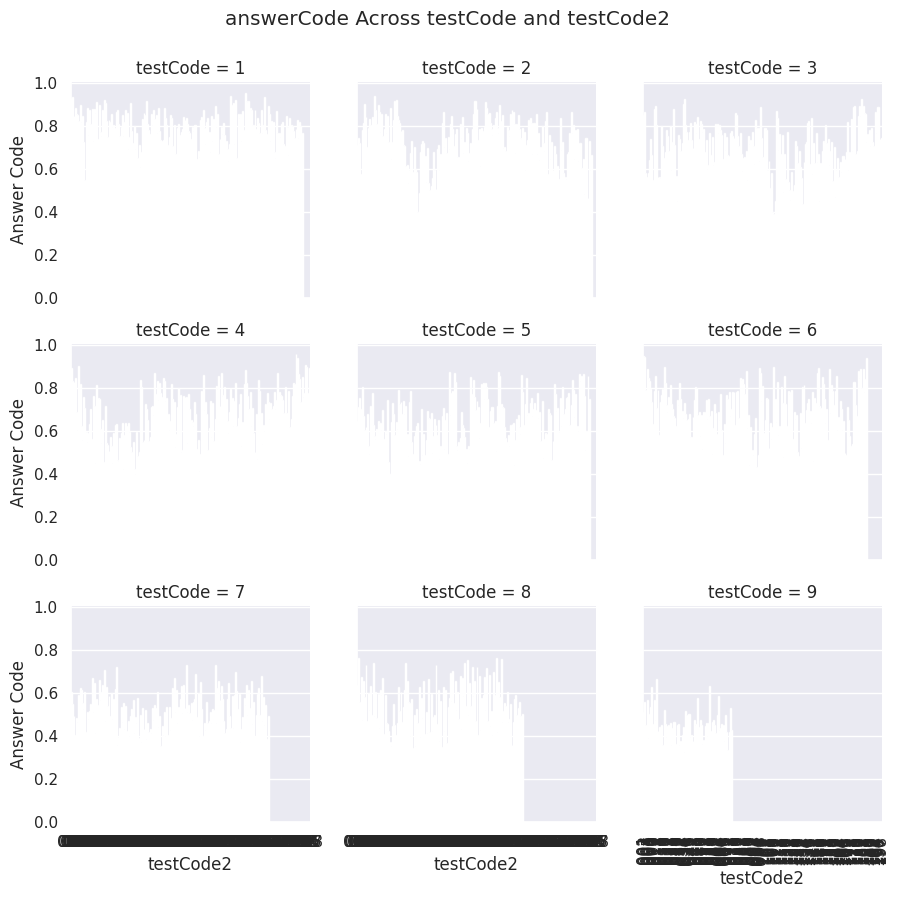

In [19]:
plt.figure(figsize = (30, 30))

test_group = train.groupby(['testCode', 'testCode2'], as_index = False).agg({'answerCode' : percentile})

g = sns.catplot(x = 'testCode2', y = 'answerCode', col = 'testCode', data = test_group, kind = 'bar', col_wrap = 3, height = 3)
g.set_axis_labels('testCode2', 'Answer Code')
g.set_titles('testCode = {col_name}')

# 전체 그래프의 제목 추가
plt.subplots_adjust(top = 0.9)
g.fig.suptitle('answerCode Across testCode and testCode2')
plt.xticks(rotation = 90)
plt.show()

- **`testID`의 2~4번째 자리**별 정답률의 차이가 있고, 번호가 커질수록 정답률이 낮아짐을 볼 수 있음
- **`testID`의 8~10번째 자리**별 정답률의 차이는 없는 듯 보임

### `Timestamp`
- 변수 생성
    - `Year`, `Month`, `Day`, `Hour`, `DayOfWeek`
    - 문제 풀이 소요 시간

#### `Year`, `Month`, `Day`, `Hour`, `DayOfWeek`별 데이터 분포

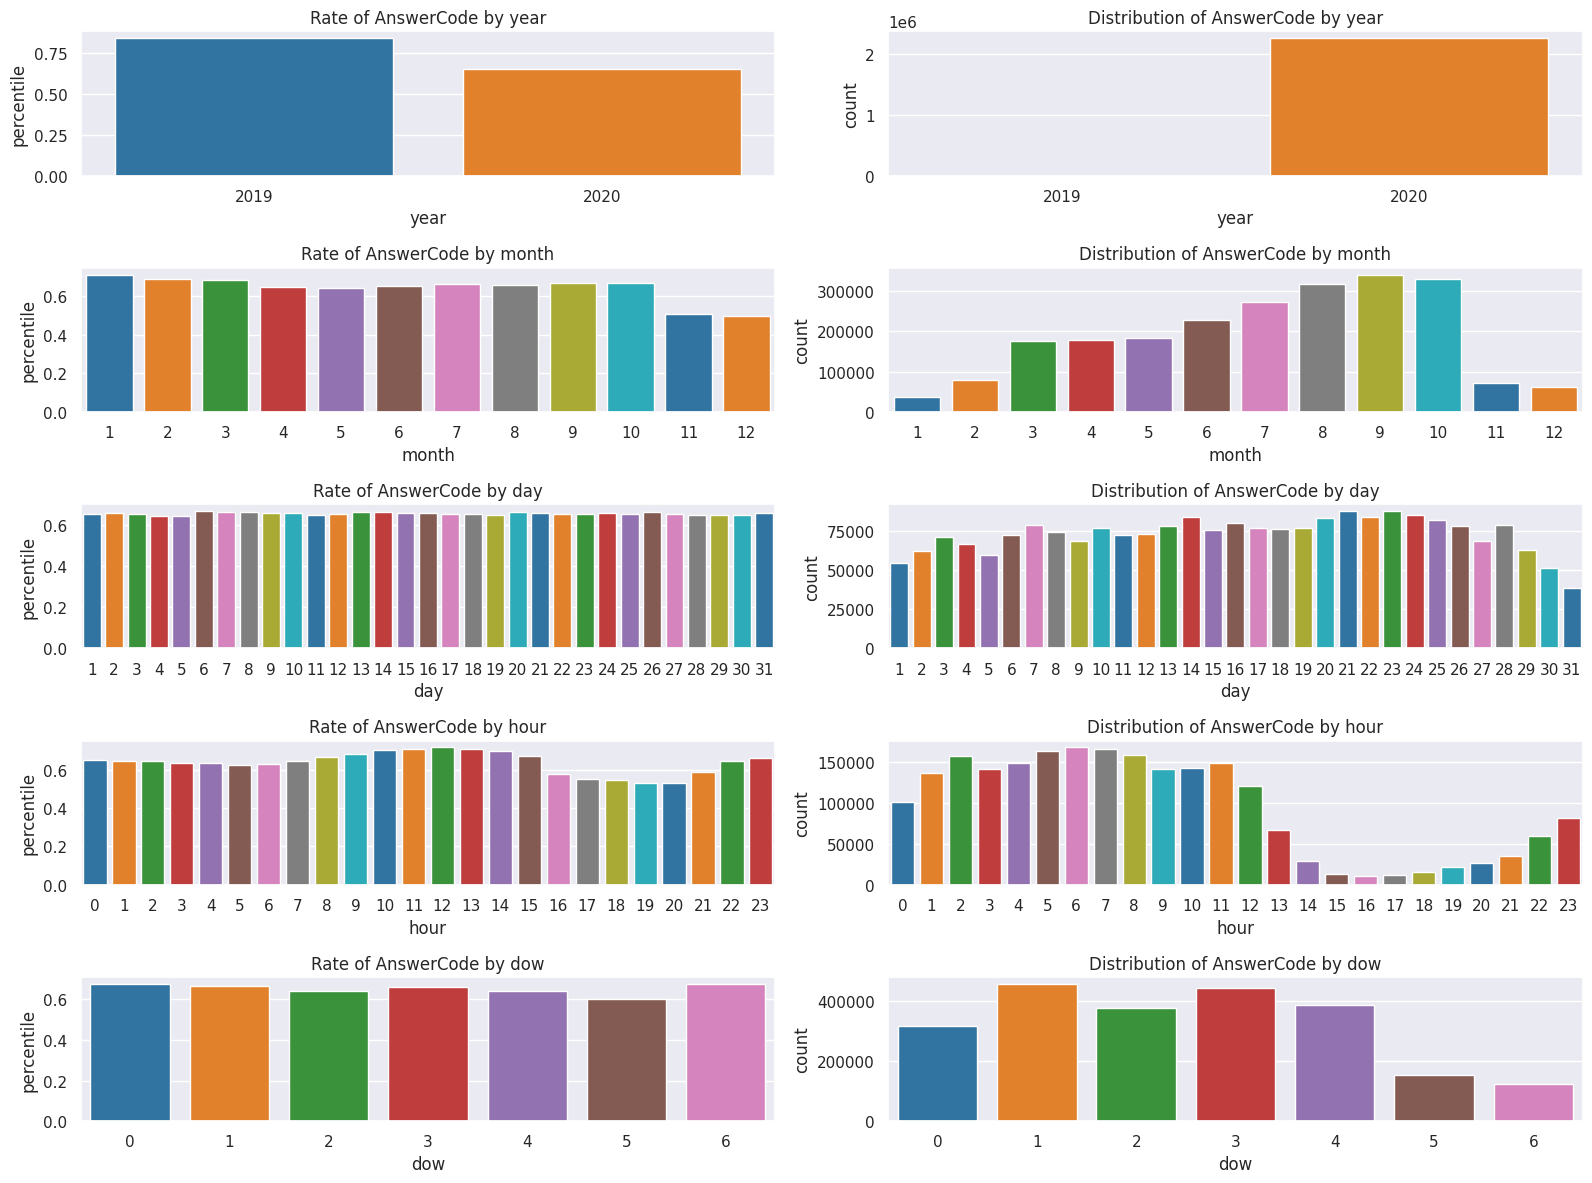

In [20]:
train['year'] = train['Timestamp'].dt.year
train['month'] = train['Timestamp'].dt.month
train['day'] = train['Timestamp'].dt.day
train['hour'] = train['Timestamp'].dt.hour
train['dow'] = train['Timestamp'].dt.dayofweek

y_ans_group = train.groupby(['year']).agg({'answerCode' : [percentile, 'count']})
m_ans_group = train.groupby(['month']).agg({'answerCode' : [percentile, 'count']})
d_ans_group = train.groupby(['day']).agg({'answerCode' : [percentile, 'count']})
h_ans_group = train.groupby(['hour']).agg({'answerCode' : [percentile, 'count']})
w_ans_group = train.groupby(['dow']).agg({'answerCode' : [percentile, 'count']})

time_group = [y_ans_group, m_ans_group, d_ans_group, h_ans_group, w_ans_group]

plt.figure(figsize = (16, 12))
k = 1
for group in time_group :
    group.columns = ['percentile', 'count']
    for value in group.columns :
        plt.subplot(5, 2, k)
        sns.barplot(x = group.index , y = value, data = group, palette = 'tab10')
        name = 'Rate' if value == 'percentile' else 'Distribution'
        plt.title(f'{name} of AnswerCode by {group.index.name}')
        k += 1
plt.tight_layout()
plt.show()

#### `ElapsedTime`
- 사용자가 해당 문제를 푸는데 걸린 시간

In [21]:
train['ElapsedTime'] = train.loc[:, ['userID', 'Timestamp']].groupby('userID').diff().shift(-1)
train['ElapsedTime'] = train['ElapsedTime'].apply(lambda x : x.total_seconds()) # second 단위로 변경

- 1. `Q3 + 1.5 * IQR` -> 결측
- 2. 10분(600초) 이상 -> 결측

In [22]:
Q1 = train['ElapsedTime'].quantile(0.25)
Q3 = train['ElapsedTime'].quantile(0.75)
IQR = Q3 - Q1
U_BOUND = Q3 + 1.5 * IQR

# print(Q1, Q3, IQR, U_BOUND)
# 13.0 136.0 123.0 320.5

# 1번
# train.loc[train['ElapsedTime'] > U_BOUND, 'ElapsedTime'] = np.nan

# 2번
train.loc[train['ElapsedTime'] > 600, 'ElapsedTime'] = np.nan

In [23]:
bins = 100

train['bins'] = pd.cut(
    train['ElapsedTime'],
    [i * (train['ElapsedTime'].max() - train['ElapsedTime'].min()) / bins for i in range(bins)]
)

train['label'] = train['bins'].apply(lambda x : (x.left + x.right) // 2)

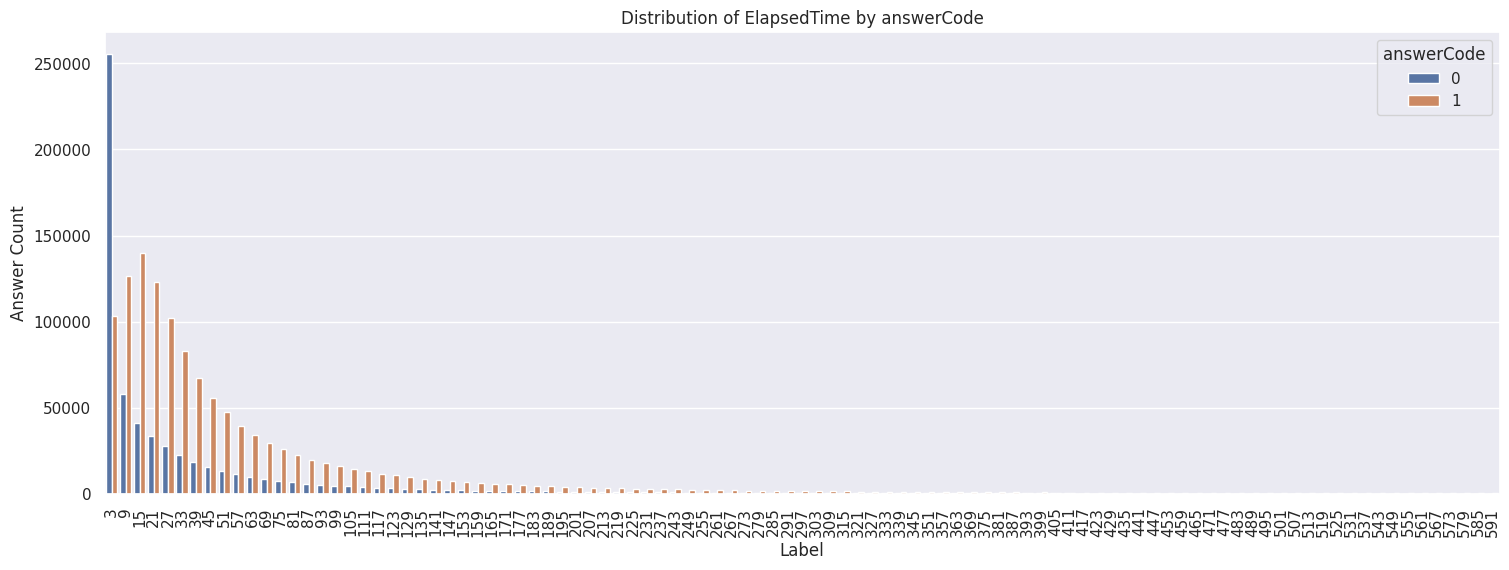

In [24]:
label_ans_groupby = train.groupby(['label', 'answerCode'], as_index = False).agg({'assessmentItemID' : 'count'})
label_ans_groupby['label'] = label_ans_groupby['label'].astype(int)

plt.figure(figsize = (18, 6))
sns.barplot(x = 'label', y = 'assessmentItemID', hue = 'answerCode', data = label_ans_groupby)
plt.title('Distribution of ElapsedTime by answerCode')
plt.xlabel('Label')
plt.ylabel('Answer Count')
plt.xticks(rotation = 90)
plt.show()

- 문제 풀이 시간이 짧을 때 (1~4, 4~8초)에 오답 비율이 매우 높음
    - 찍은 문제일 확률이 높음

- 유저별 평균 `ElapsedTime`에 따른 평균 정답률의 분포

사용자 별 평균 문제 푼 시간과 평균 정답률 사이 상관관계: 0.456


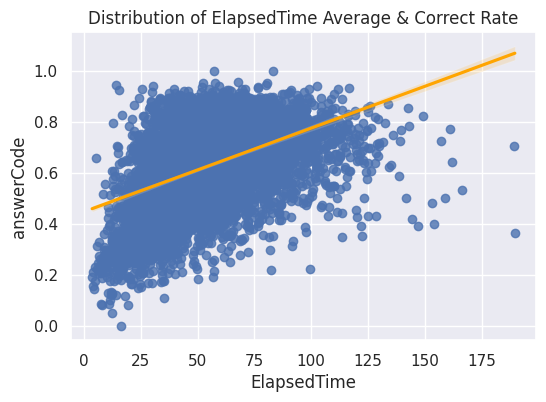

In [25]:
user_et_group = train.groupby('userID', as_index = False).agg({'ElapsedTime' : 'mean', 'answerCode' : percentile})

print(f"사용자 별 평균 문제 푼 시간과 평균 정답률 사이 상관관계: {user_et_group.corr()['ElapsedTime']['answerCode']:.3f}")

plt.figure(figsize = (6, 4))
sns.regplot(x = 'ElapsedTime', y = 'answerCode', data = user_et_group, line_kws = {'color' : 'orange'})
plt.title('Distribution of ElapsedTime Average & Correct Rate')
plt.show()

- `ElapsedTime`과 평균 정답률 사이의 관계

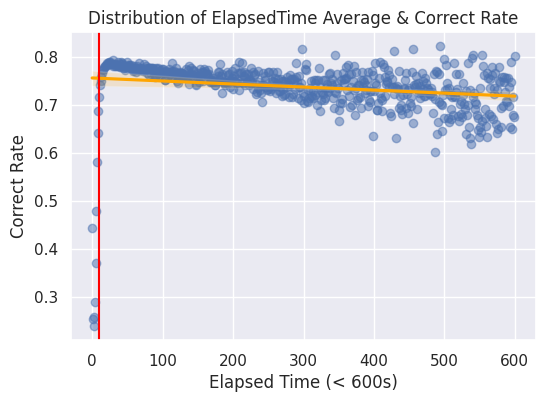

In [26]:
et_ans_group = train.groupby('ElapsedTime', as_index = False).agg({'answerCode' : percentile, 'userID' : 'count'})

plt.figure(figsize = (6, 4))
sns.regplot(x = 'ElapsedTime', y = 'answerCode', data = et_ans_group,
            scatter_kws = {'alpha' : 0.5}, line_kws = {'color' : 'orange'})
plt.title('Distribution of ElapsedTime Average & Correct Rate')
plt.xlabel('Elapsed Time (< 600s)')
plt.ylabel('Correct Rate')
plt.axvline(10, color = 'red') # 9~10초부터 전체 평균 정답률인 0.65를 넘어서기 시작
plt.show()

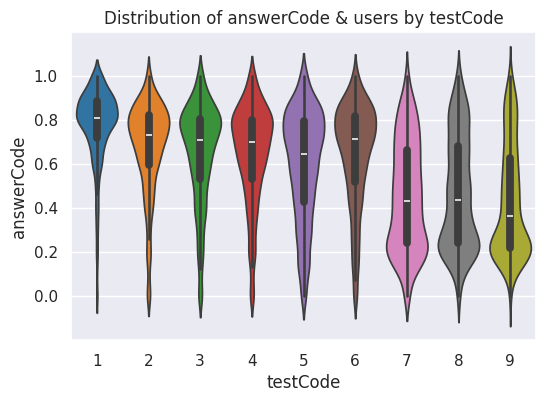

In [27]:
user_tc_group = train.groupby(['userID', 'testCode'], as_index = False).agg({'answerCode' : percentile}).sort_values(by = ['testCode', 'userID'])

plt.figure(figsize = (6, 4))
sns.violinplot(x = 'testCode', y = 'answerCode', data = user_tc_group, palette = 'tab10')
plt.title('Distribution of answerCode & users by testCode')
plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
plt.show()

### `KnowledgeTag`

In [28]:
code = '1'
train.loc[train['testCode'] == code, 'KnowledgeTag'].unique()

array([5485, 7581, 5834, 7593, 6308, 7597, 7600, 7596, 7599, 6456, 7621,
       7618, 7620, 6555, 6556, 6648, 6775, 7803, 5814, 5844, 5846, 7595,
       7598, 7601, 6453, 6454, 6455, 6557, 5836, 6803, 6806, 5845, 6804,
       6774, 6647, 6805, 7807, 7810, 7802, 7797, 7811, 7801, 7800, 7073,
       7070, 7626, 7629, 6649, 7076, 6777, 7798, 7799, 6794, 6807, 6307,
       7809, 7804, 7812, 7072, 7075, 7815, 7805, 7808, 7813], dtype=int16)

In [38]:
all_tags = set()
test_code_tags = {}

for code in sorted(train['testCode'].unique()) :
    tags = set(train.loc[train['testCode'] == code, 'KnowledgeTag'].unique())
    
    duplicated_tags = tags.intersection(all_tags)
    all_tags.update(tags)
    test_code_tags[code] = tags
    
    if duplicated_tags :
        print(f'Duplicated Tag in Test Code {code} : {duplicated_tags}')

print('\nTest Code Tags : ')
for code, tags in test_code_tags.items() :
    print(f'Test Code {code} : {tags}')

Duplicated Tag in Test Code 8 : {7863}

Test Code Tags : 
Test Code 1 : {7808, 7809, 7810, 7811, 7812, 7813, 7815, 6794, 6803, 6804, 6805, 6806, 6807, 6555, 6556, 6557, 7070, 7581, 7072, 7073, 6307, 6308, 7075, 7076, 6775, 7593, 7595, 7596, 7597, 7598, 7599, 7600, 6777, 7601, 6453, 5814, 6454, 6456, 6455, 7618, 7620, 7621, 7799, 5834, 7626, 5836, 7629, 7800, 7801, 5844, 5845, 5846, 7802, 5485, 7797, 6774, 6647, 6648, 6649, 7798, 7803, 7804, 7805, 7807}
Test Code 2 : {7936, 7938, 7941, 7943, 7944, 7693, 7694, 7822, 7696, 8091, 8092, 8093, 8094, 8095, 8096, 8097, 8122, 8123, 8124, 8125, 8126, 8127, 8129, 8002, 7747, 8003, 8004, 8005, 7751, 8006, 8130, 8131, 8132, 8133, 8134, 8014, 8015, 8016, 8017, 8018, 8019, 8020, 8021, 8022, 8023, 8027, 8135, 8136, 7912, 7913, 7914, 7915, 7916, 8137, 7918, 7919, 7920, 7921, 7922, 7924, 7925, 7926, 7927, 7928, 7929, 7930, 7932, 7933, 7934, 7935}
Test Code 3 : {7690, 7691, 547, 551, 554, 559, 574, 7781, 7782, 7788, 7789, 7817, 7818, 7307, 7308, 7309, 73

In [48]:
all_tags = set()
test_code_tags = {}

test['testCode'] = test['testId'].apply(lambda x : x[2:3])

for code in sorted(test['testCode'].unique()) :
    tags = set(test.loc[test['testCode'] == code, 'KnowledgeTag'].unique())
    
    duplicated_tags = tags.intersection(all_tags)
    all_tags.update(tags)
    test_code_tags[code] = tags
    
    if duplicated_tags :
        print(f'Duplicated Tag in Test Code {code} : {duplicated_tags}')

print('\nTest Code Tags : ')
for code, tags in test_code_tags.items() :
    print(f'Test Code {code} : {tags}')

Duplicated Tag in Test Code 8 : {7863}

Test Code Tags : 
Test Code 1 : {7808, 7809, 7810, 7811, 7812, 7813, 7815, 6794, 6803, 6804, 6805, 6806, 6807, 6555, 6556, 7581, 6557, 7070, 7072, 7073, 6647, 7076, 6308, 7075, 6307, 7593, 7595, 7596, 7597, 7598, 6649, 7600, 7599, 7601, 6453, 6454, 6455, 6456, 5814, 7618, 7620, 7621, 7799, 7626, 5834, 5836, 7629, 7800, 7801, 5844, 5845, 5846, 7802, 5485, 7797, 6774, 6775, 6648, 6777, 7798, 7803, 7804, 7805, 7807}
Test Code 2 : {7936, 7938, 7941, 7943, 7944, 7693, 7694, 7822, 7696, 8131, 8091, 8092, 8093, 8094, 8095, 8096, 8097, 8122, 8123, 8124, 8125, 8126, 8127, 8129, 8002, 7747, 8004, 8003, 8005, 7751, 8006, 8133, 8134, 8137, 8136, 8135, 8014, 8015, 8016, 8017, 8018, 8019, 8020, 8021, 8022, 8023, 8132, 8027, 7912, 7913, 7914, 7915, 7916, 7918, 7919, 7920, 7921, 7922, 7924, 7925, 7926, 7927, 7928, 7929, 7930, 8130, 7932, 7933, 7934, 7935}
Test Code 3 : {7690, 7691, 547, 551, 554, 559, 574, 7781, 7782, 7788, 7789, 7817, 7818, 7307, 7308, 7309, 73

In [44]:
print(train[train['KnowledgeTag'] == 7863]['testCode'].value_counts(), end = '\n\n')
train.loc[train['KnowledgeTag'] == 7863, 'testCode'] = 7
print(train[train['KnowledgeTag'] == 7863]['testCode'].nunique())

testCode
7    1821
Name: count, dtype: int64

1


In [30]:
tag_group = train.groupby('KnowledgeTag').agg({'answerCode' : [percentile, 'count']})
tag_group.columns = ['percentile', 'count']
tag_group

,percentile,count
KnowledgeTag,,
23,0.584444,1800
24,0.614525,358
25,0.858696,92
26,0.614309,2432
30,0.536178,539
...,...,...
11253,0.739374,4282
11265,0.676211,454
11269,0.557716,2417


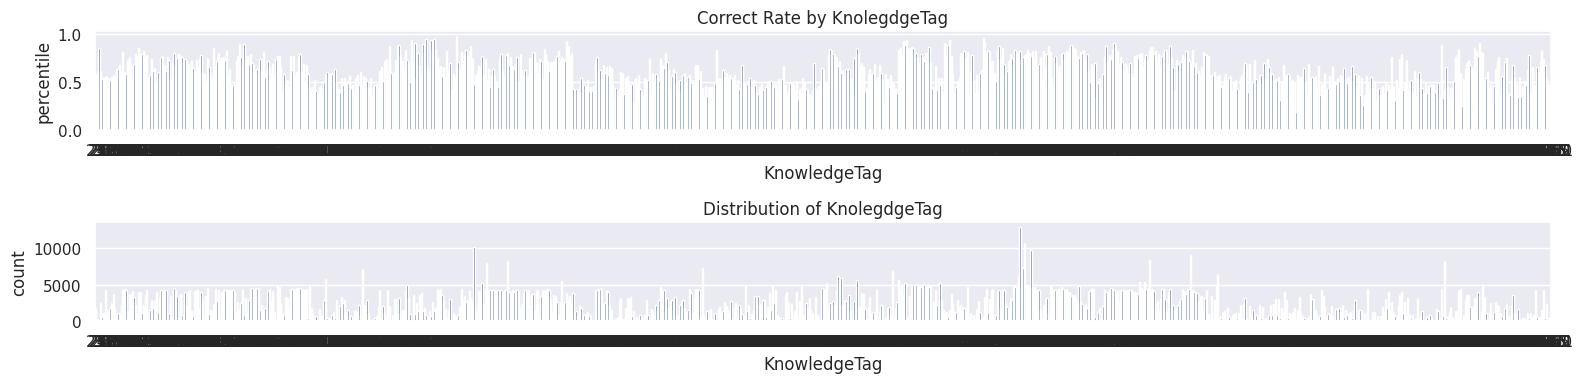

In [31]:
plt.figure(figsize = (16, 4))

plt.subplot(2, 1, 1)
sns.barplot(x = 'KnowledgeTag', y = 'percentile', data = tag_group)
plt.title('Correct Rate by KnolegdgeTag')

plt.subplot(2, 1, 2)
sns.barplot(x = 'KnowledgeTag', y = 'count', data = tag_group)
plt.title('Distribution of KnolegdgeTag')

plt.tight_layout()
plt.show()

- 더 많이 노출된 태그가 정답률이 더 높은가 ?

태그를 풀었던 사용자의 수와 정답률 사이 상관관계: 0.376


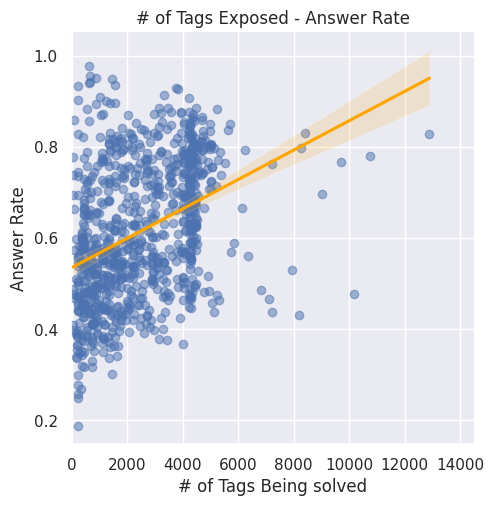

In [32]:
tag_groupby = train.groupby('KnowledgeTag', as_index = False).agg(
    {'userID' : 'count', 'answerCode' : percentile})

print(f"태그를 풀었던 사용자의 수와 정답률 사이 상관관계: {tag_groupby.corr()['answerCode']['userID']:.3f}")

g = sns.lmplot(
    data = tag_groupby,
    x = 'userID',
    y = 'answerCode',
    scatter_kws = {'alpha': 0.5},
    line_kws = {'color' : 'orange'}
)
g.set_xlabels('# of Tags Being solved')
g.set_ylabels('Answer Rate')
g.set(xlim=(-30, 14500))

ax = plt.gca()
ax.set_title('# of Tags Exposed - Answer Rate')
plt.show()

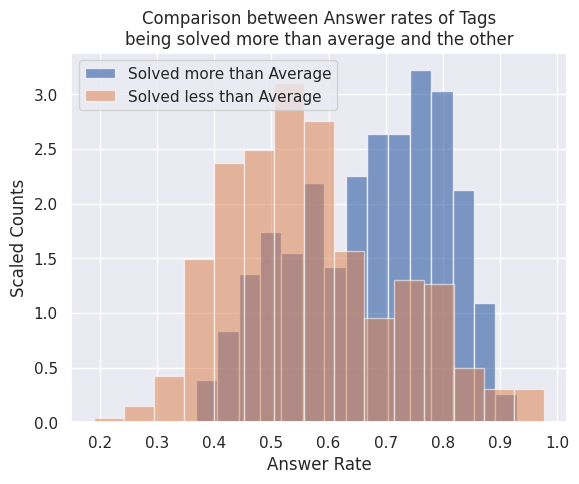

In [33]:
fig, ax = plt.subplots()

tag_ans_mean = tag_groupby['userID'].mean()
ax.set_xlabel('Answer Rate')
ax.set_ylabel('Scaled Counts')
ax.set_title('Comparison between Answer rates of Tags\nbeing solved more than average and the other')

tag_groupby[tag_groupby['userID'] >= tag_ans_mean]['answerCode'].hist(
    ax = ax, alpha = 0.7, bins = 15, density = 1, stacked = True, label = 'Solved more than Average'
)
tag_groupby[tag_groupby['userID'] < tag_ans_mean]['answerCode'].hist(
    ax = ax, alpha = 0.55, bins = 15, density = 1, stacked = True, label = 'Solved less than Average'
)
ax.legend()
plt.show()

### `answerCode`

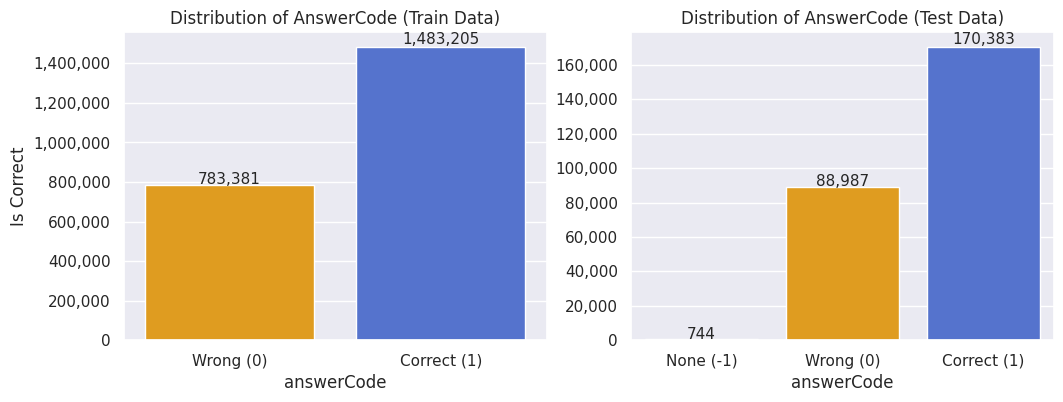

In [30]:
plt.figure(figsize = (12, 4))

plt.subplot(1, 2, 1)
ax = sns.countplot(x = 'answerCode', data = train, palette = ['orange', 'royalblue'])
ax.set_xticklabels(['Wrong (0)', 'Correct (1)'])
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: '{:,.0f}'.format(y)))

for p in ax.patches:
    left, bottom, width, height = p.get_bbox().bounds
    ax.annotate('{:,.0f}'.format(height), (left + width / 2, height * 1.01),
                ha = 'center', fontsize = 11)

plt.title('Distribution of AnswerCode (Train Data)')
plt.ylabel('Is Correct')

plt.subplot(1, 2, 2)
ax = sns.countplot(x = 'answerCode', data = test, palette = ['gray', 'orange', 'royalblue'])
ax.set_xticklabels(['None (-1)', 'Wrong (0)', 'Correct (1)'])
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: '{:,.0f}'.format(y)))

for p in ax.patches:
    left, bottom, width, height = p.get_bbox().bounds
    ax.annotate('{:,.0f}'.format(height), (left + width / 2, height * 1.01),
                ha = 'center', fontsize = 11)

plt.title('Distribution of AnswerCode (Test Data)')
plt.ylabel('')
plt.show()

### `problemID` & `testCode`
- 어떻게 해석해야할까 ..

In [31]:
pd.crosstab(index = train['problemID'], columns = train['testCode'])

testCode,1,2,3,4,5,6,7,8,9
problemID,,,,,,,,,
001,53217,50254,50705,51196,41975,40450,34563,32337,17058
002,52540,50561,50657,51196,41697,40498,34563,32337,16923
003,53171,50146,50478,51196,42106,40585,34563,32337,17058
004,52862,49904,50568,50403,42106,39904,34563,32337,17058
005,49758,49258,50565,48396,40735,37985,34563,32289,17058
006,8165,12765,12529,10930,36178,33466,34344,32337,17058
007,1607,2726,3069,1600,29591,28356,26354,25232,8586
008,762,1367,2255,533,693,1591,26131,25232,8586
009,0,806,1837,533,460,1137,12875,769,0


### `problemID`
- `assessmentItemID`의 8~10번째 자리를 추출
- 위에서, `problemID`별 정답률의 차이가 유의미함을 그래프로 보았음

- 유저별 `problemID`에 따른 정답률 평균의 분포

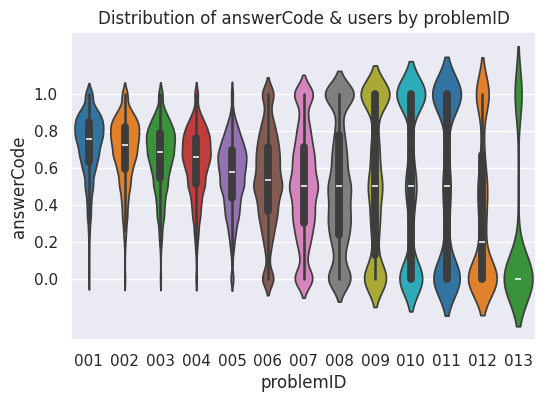

In [32]:
user_pb_group = train.groupby(['userID', 'problemID'], as_index = False).agg({'answerCode' : percentile}).sort_values(by = ['problemID', 'userID'])

plt.figure(figsize = (6, 4))
sns.violinplot(x = 'problemID', y = 'answerCode', data = user_pb_group, palette = 'tab10')
plt.title('Distribution of Correct Rate of users by problemID')
plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
plt.show()

- `testCode`별 `problemID`에 따른 정답률 평균의 분포

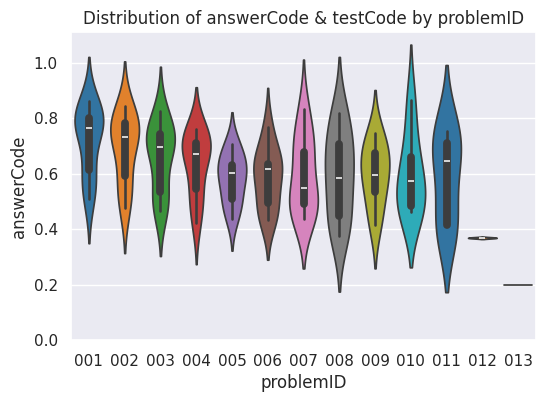

In [33]:
tc_pb_group = train.groupby(['testCode', 'problemID'], as_index = False).agg({'answerCode' : percentile}).sort_values(by = ['problemID', 'testCode'])

plt.figure(figsize = (6, 4))
sns.violinplot(x = 'problemID', y = 'answerCode', data = tc_pb_group, palette = 'tab10')
plt.title('Distribution of Correct Rate of testCode by problemID')
plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
plt.show()

- `problemID`별 `ElapsedTime`의 분포

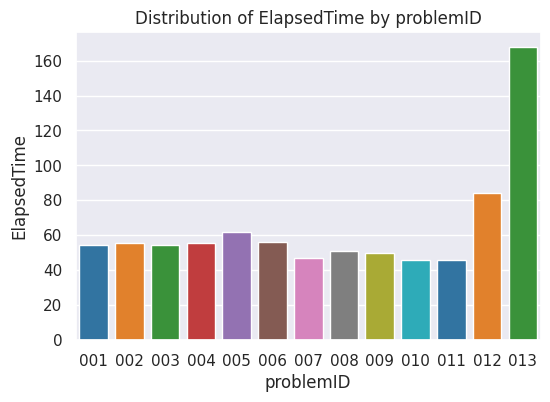

In [87]:
pb_et_group = train.groupby('problemID', as_index = False).agg({'ElapsedTime' : 'mean'})

plt.figure(figsize = (6, 4))
sns.barplot(x = 'problemID', y = 'ElapsedTime', data = pb_et_group, palette = 'tab10')
plt.title('Distribution of ElapsedTime by problemID')
plt.show()

### `testCode`
- `TestId`의 3번째 자리를 추출
- 위에서, `testCode`별 정답률의 차이가 유의미함을 그래프로 보았음

- 유저별 `testCode`에 따른 정답률 평균의 분포

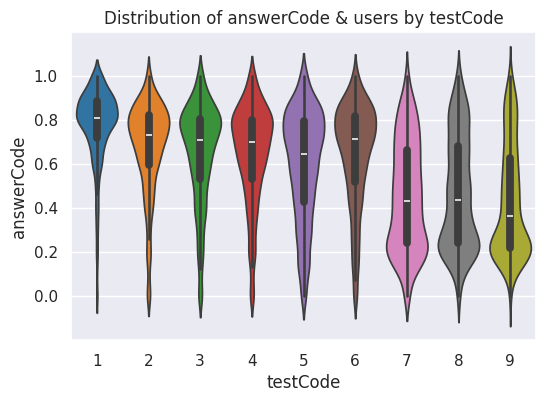

In [34]:
user_tc_group = train.groupby(['userID', 'testCode'], as_index = False).agg({'answerCode' : percentile}).sort_values(by = ['testCode', 'userID'])

plt.figure(figsize = (6, 4))
sns.violinplot(x = 'testCode', y = 'answerCode', data = user_tc_group, palette = 'tab10')
plt.title('Distribution of answerCode & users by testCode')
plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
plt.show()

- 문항별 `testCode`에 따른 정답률 평균의 분포

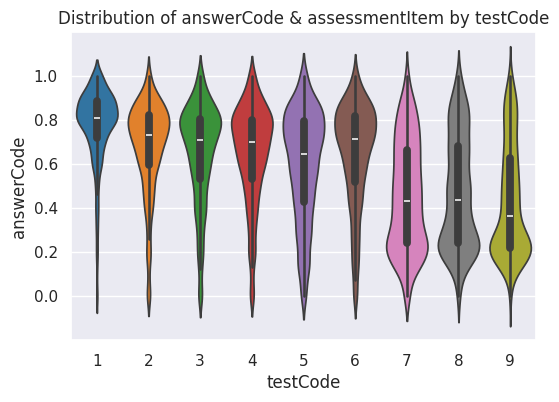

In [35]:
item_tc_group = train.groupby(['assessmentItemID', 'testCode'], as_index = False).agg({'answerCode' : percentile}).sort_values(by = ['testCode', 'assessmentItemID'])

plt.figure(figsize = (6, 4))
sns.violinplot(x = 'testCode', y = 'answerCode', data = user_tc_group, palette = 'tab10')
plt.title('Distribution of answerCode & assessmentItem by testCode')
plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
plt.show()

- 문제 번호별 `testCode`에 따른 정답률 평균의 분포 (문항별 분포와 별 차이가 없는 것 같기도 ..)

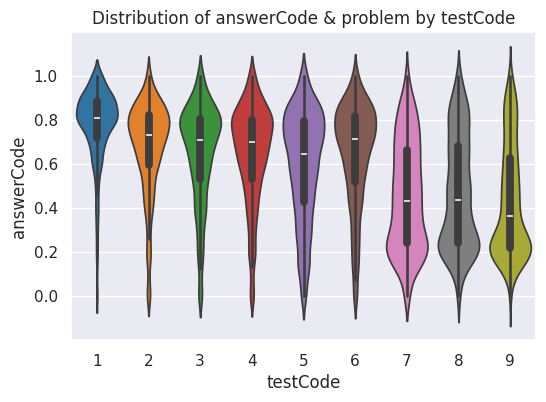

In [36]:
pb_tc_group = train.groupby(['problemID', 'testCode'], as_index = False).agg({'answerCode' : percentile}).sort_values(by = ['testCode', 'problemID'])

plt.figure(figsize = (6, 4))
sns.violinplot(x = 'testCode', y = 'answerCode', data = user_tc_group, palette = 'tab10')
plt.title('Distribution of answerCode & problem by testCode')
plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
plt.show()

- `testCode`를 1~6과 7~9로 나누어주는 것도 좋을 것 같음
    - ex) 6이하 -> 0 / 7이상 -> 1

### 가설 설정 후 검정

#### 문항을 더 많이 푼 학생이 문제를 더 맞추는가?

정답률과 문제를 푼 개수 사이 인과관계 : 0.168


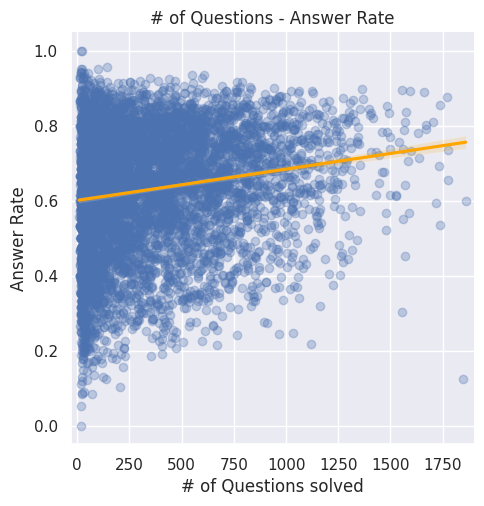

In [37]:
print(f"정답률과 문제를 푼 개수 사이 인과관계 : {stu_groupby.corr()['assessmentItemID']['answerCode']:.3f}")

g = sns.lmplot(
    data = stu_groupby,
    x = 'assessmentItemID',
    y = 'answerCode',
    scatter_kws = {'alpha' : 0.3},
    line_kws = {'color' : 'orange'}
)
g.set_xlabels('# of Questions solved')
g.set_ylabels('Answer Rate')
g.set(xlim = (-30, 1900))

ax = plt.gca()
ax.set_title('# of Questions - Answer Rate')
plt.show()

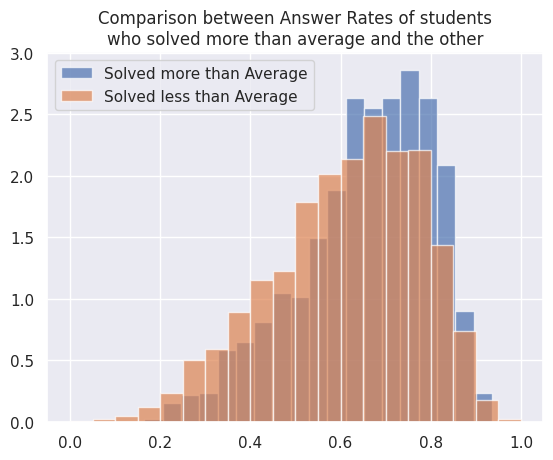

In [38]:
fig, ax = plt.subplots()

ax.set_title('Comparison between Answer Rates of students\nwho solved more than average and the other')
stu_num_mean = stu_groupby['assessmentItemID'].mean()
stu_groupby[stu_groupby['assessmentItemID'] >= stu_num_mean]['answerCode'].hist(
    bins = 20, ax = ax, alpha = 0.7, stacked = True, density = 1, label = 'Solved more than Average'
)
stu_groupby[stu_groupby['assessmentItemID'] < stu_num_mean]['answerCode'].hist(
    bins = 20, ax = ax, alpha = 0.7, stacked = True, density = 1, label = 'Solved less than Average'
)
ax.legend()
plt.show()

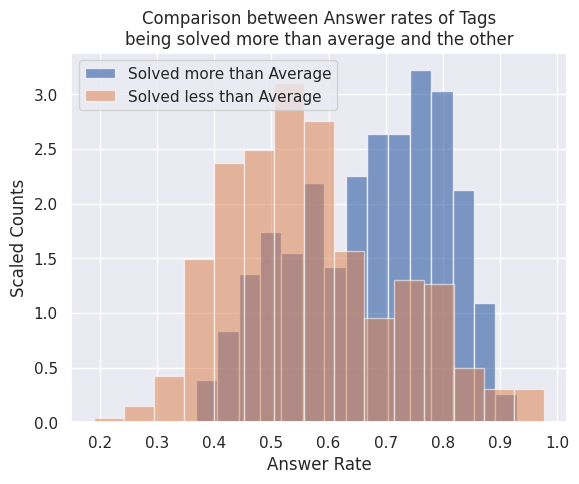

In [35]:
fig, ax = plt.subplots()

tag_ans_mean = tag_groupby['userID'].mean()
ax.set_xlabel('Answer Rate')
ax.set_ylabel('Scaled Counts')
ax.set_title('Comparison between Answer rates of Tags\nbeing solved more than average and the other')

tag_groupby[tag_groupby['userID'] >= tag_ans_mean]['answerCode'].hist(
    ax = ax, alpha = 0.7, bins = 15, density = 1, stacked = True, label = 'Solved more than Average'
)
tag_groupby[tag_groupby['userID'] < tag_ans_mean]['answerCode'].hist(
    ax = ax, alpha = 0.55, bins = 15, density = 1, stacked = True, label = 'Solved less than Average'
)
ax.legend()
plt.show()

#### 문항을 풀수록 실력이 늘어나는가?

In [42]:
# 누적합
_cumsum = train.loc[:, ['userID', 'answerCode']].groupby('userID').agg({'answerCode' : 'cumsum'})
# 누적갯수
_cumcount = train.loc[:, ['userID', 'answerCode']].groupby('userID').agg({'answerCode' : 'cumcount'}) + 1

cum_ans = _cumsum / _cumcount
cum_ans['userID'] = train['userID']
window_sizes = [30, 70, 100, 120]

푼 문항의 갯수가 중앙값 부근인 10명의 학생들

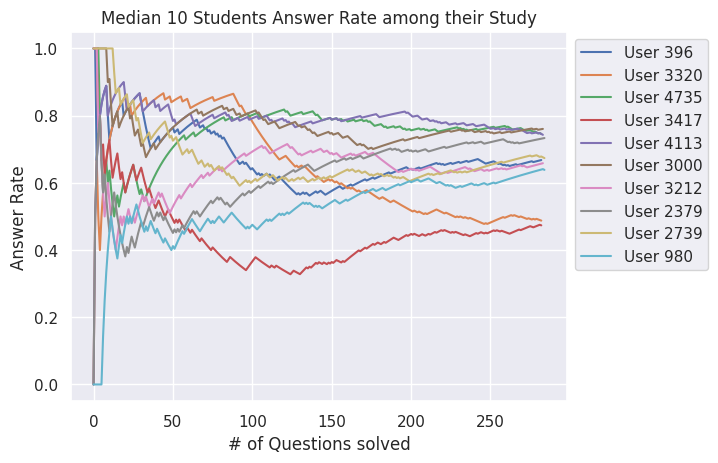

In [43]:
fig, ax = plt.subplots()
ax.set_title('Median 10 Students Answer Rate among their Study')
ax.set_xlabel('# of Questions solved')
ax.set_ylabel('Answer Rate')

samples = train.groupby('userID').agg({'assessmentItemID' : 'count'}).sort_values(by = 'assessmentItemID').index[7442//2-5:7442//2+5]
for idx in samples :
    cum_ans[cum_ans['userID'] == idx]['answerCode'].reset_index(drop = True).plot(ax = ax, label = f'User {idx}')
ax.legend(bbox_to_anchor = (1, 1))

정답률이 중앙값 부근인 10명의 학생들

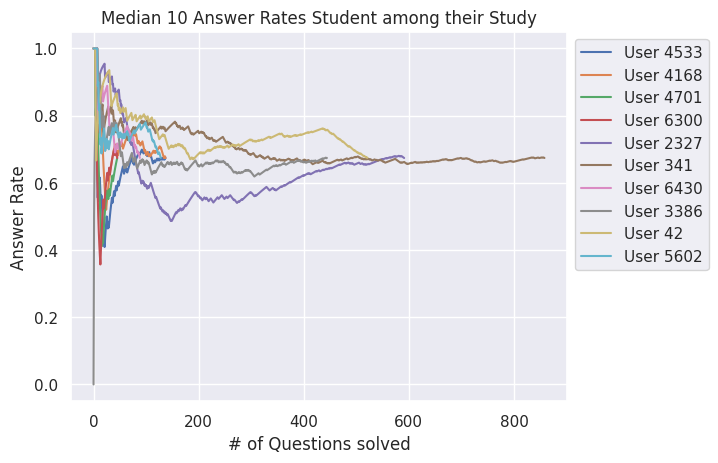

In [44]:
fig, ax = plt.subplots()
ax.set_title('Median 10 Answer Rates Student among their Study')
ax.set_xlabel('# of Questions solved')
ax.set_ylabel('Answer Rate')

samples = train.groupby('userID').agg({'answerCode' : percentile}).sort_values(by = 'answerCode').index[7442//2-5:7442//2+5]
for idx in samples :
    cum_ans[cum_ans['userID'] == idx]['answerCode'].reset_index(drop = True).plot(ax = ax, label = f'User {idx}')
ax.legend(bbox_to_anchor = (1, 1))

Window_size 적용

In [45]:
def plot_rolled_answerrate(userID, ax, window_sizes = [70, 100, 120]) :
    
    ax.set_title(f'Students Answer Rate among their Study - User {userID}')
    ax.set_xlabel('# of Questions solved')
    ax.set_ylabel('Answer Rate')

    cum_ans[cum_ans['userID'] == userID]['answerCode'].reset_index(drop = True).plot(
        ax = ax, label = f'Without Window', linewidth = 3)

    for wdw_sz in window_sizes :    
        (train[train.userID == userID]['answerCode'].rolling(wdw_sz).sum().reset_index(drop = True) / wdw_sz).plot(
            ax = ax, label = f'Window size {wdw_sz}', alpha = 0.8)

    ax.legend()

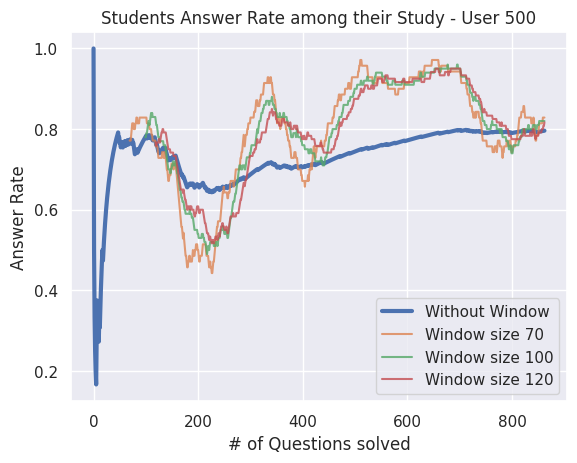

In [46]:
fig, ax = plt.subplots()
plot_rolled_answerrate(500, ax)

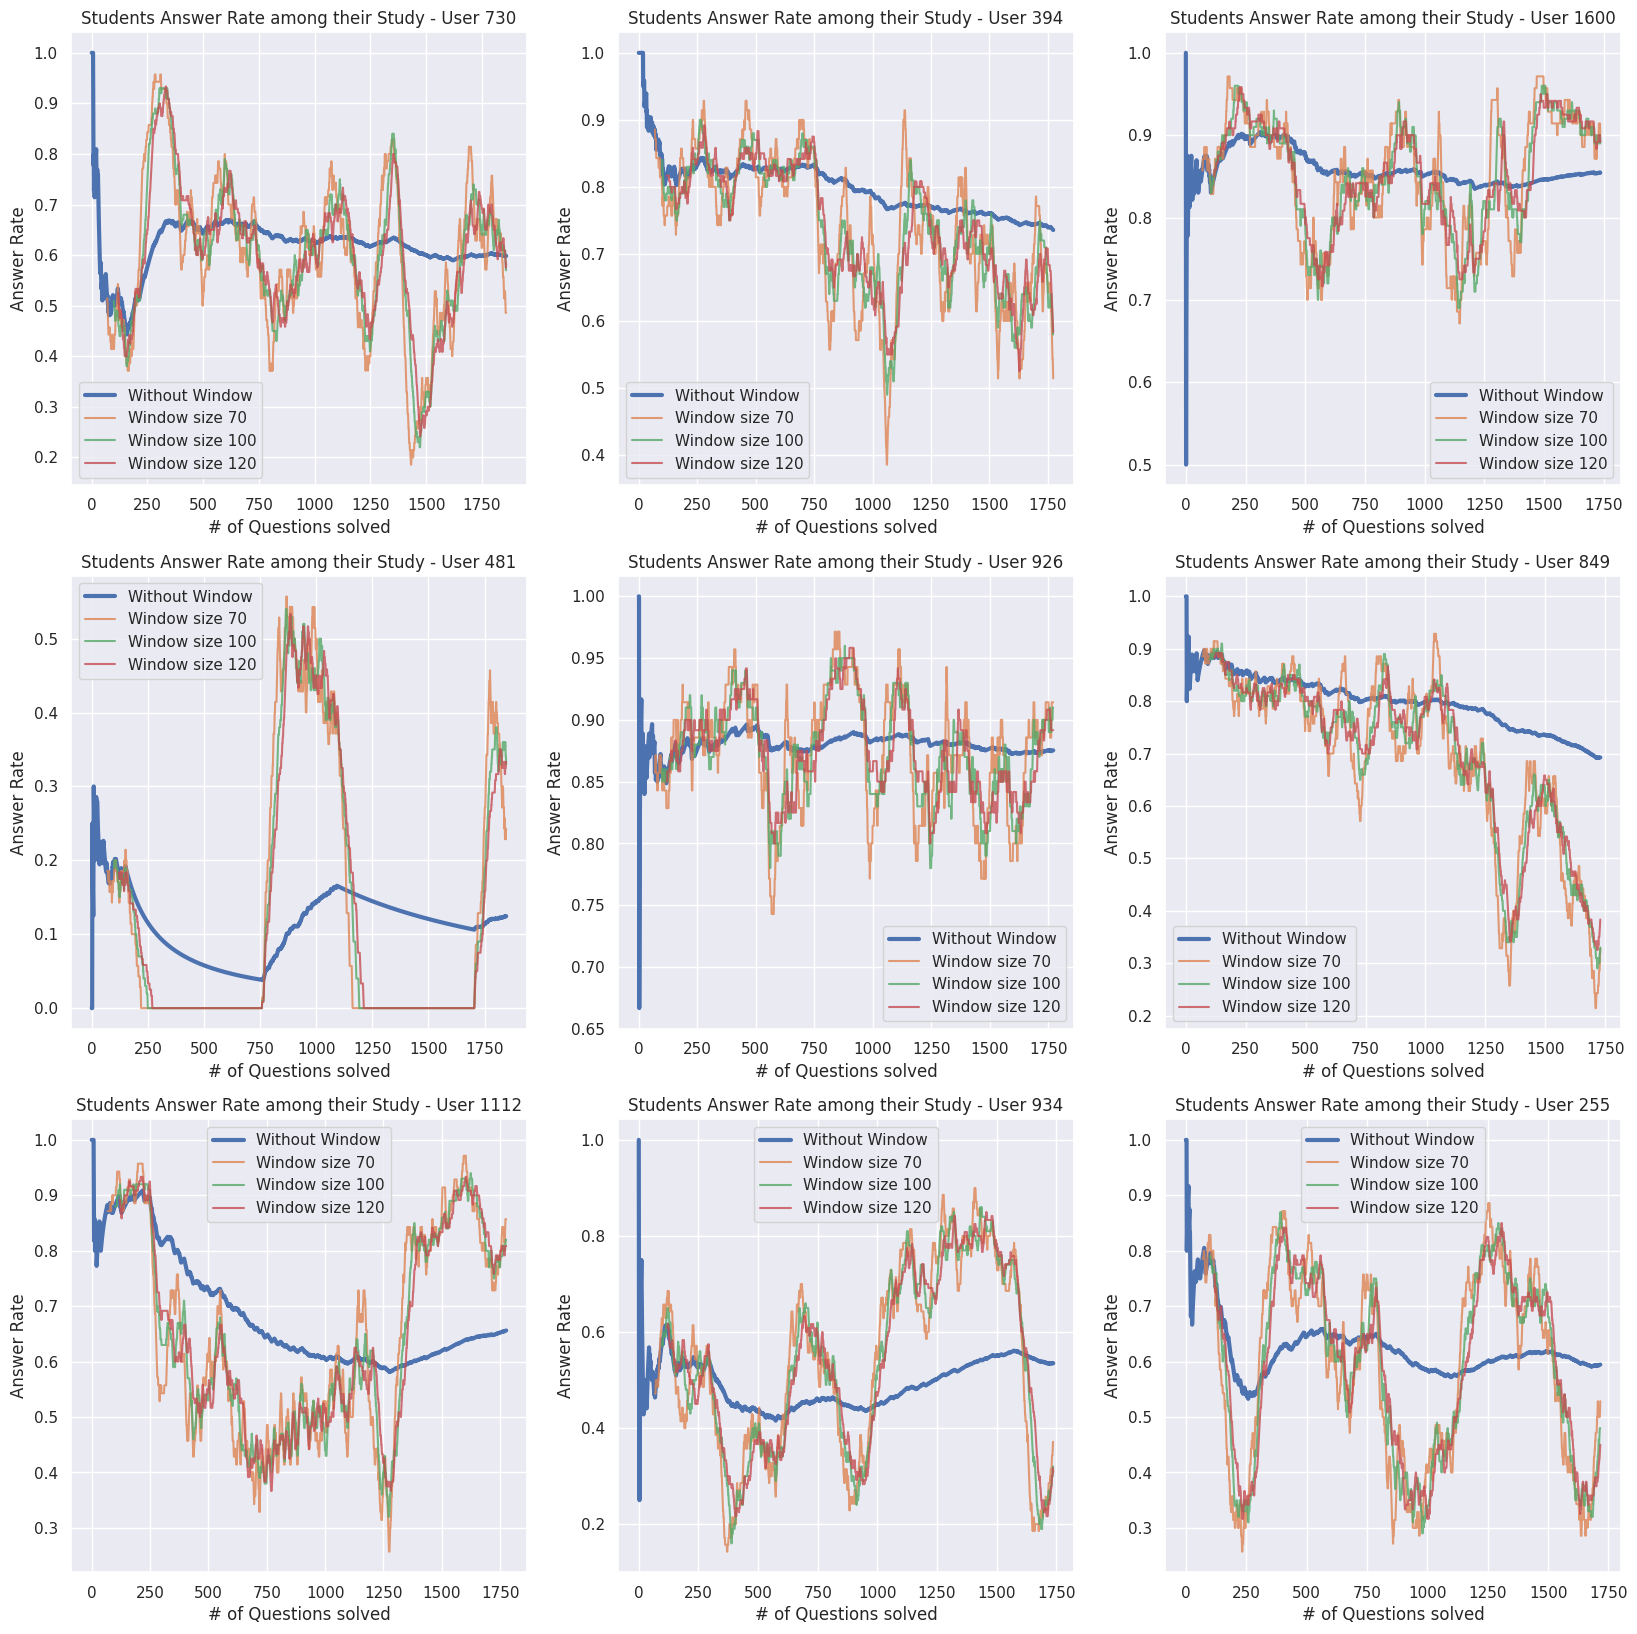

In [47]:
idx = train.groupby('userID').agg({'answerCode' : 'count'}).sort_values(by = 'answerCode', ascending = False).iloc[:9].index
fig, axes = plt.subplots(nrows = 3, ncols = 3, figsize = (20, 20))
plt.title('Top 9 Students who solved the most problems')
for i, userID in enumerate(idx) :
    r, c = i%3, i//3
    plot_rolled_answerrate(userID, axes[r, c])